In [1]:
import h5py
import brighteyes_flim
import matplotlib.pyplot as plt
import numpy as np
import brighteyes_ism.analysis.Graph_lib as gr
import brighteyes_ism.dataio.mcs as mcs
from scipy.optimize import curve_fit
from skimage.filters import gaussian
import scipy.signal
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

### Load the data and realign the temporal bins 

In [2]:
data = h5py.File(r"C:\Users\fdelbufalo\Desktop\images\Lamina_Tubulin\Lamina.h5", "r") 
print(data.keys())
image = data["data"]
image = np.sum(image, axis=(0,1), dtype=np.uint16)
print(image.shape)

<KeysViewHDF5 ['configurationFPGA', 'configurationGUI', 'configurationGUI_beforeStart', 'configurationSpadFCSmanager', 'data', 'data_channels_extra']>
(1250, 1250, 81, 25)


In [3]:
data_path_irf = r"\\iitfsvge101.iit.local\mms\Data MMS server\STED-ISM\AxialDeconvolution\flim\lamina+tubulin\data-10-04-2024-19-50-34.h5" 
data_irf = h5py.File(data_path_irf)

image_irf = data_irf["data"]
image_irf = np.sum(image_irf, axis=(0,1))
print(image_irf.shape)


(500, 500, 81, 25)
hist shape ()


In [4]:
data_hist_irf = np.sum(image_irf, axis=(0, 1))
print('hist shape', data_hist_irf.shape)

hist shape (81, 25)


In [5]:
nch = data_hist_irf.shape[-1]
print("nchannels", nch)

shift_vec = np.empty( nch )

for i in range(nch):
    shift_vec[i], *_ = phase_cross_correlation(data_hist_irf[:, 12], data_hist_irf[:, i], upsample_factor=10, normalization=None)


irf_shifted = np.empty_like(data_hist_irf)
for i in range(nch):
    irf_shifted[:, i] = shift(data_hist_irf[:, i], shift_vec[i], order = 1, mode='grid-wrap')

nchannels 25


C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_26268\497687592.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shift_vec[i], *_ = phase_cross_correlation(data_hist_irf[:, 12], data_hist_irf[:, i], upsample_factor=10, normalization=None)


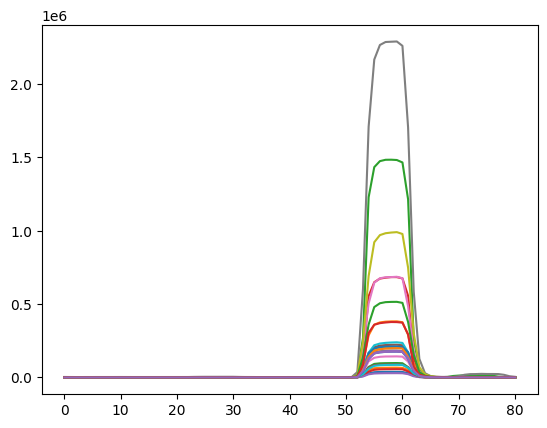

In [6]:
plt.figure()
for i in range(nch):
    plt.plot(irf_shifted[:,i])


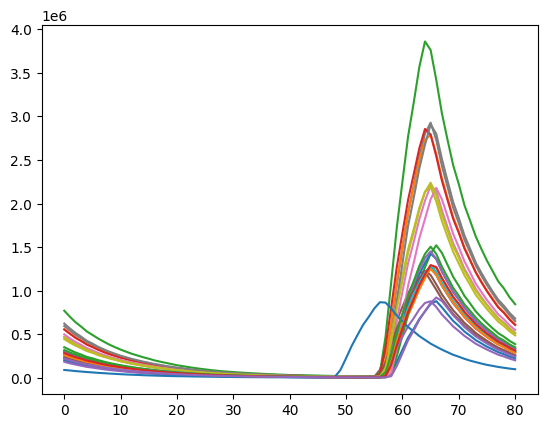

In [7]:
plt.figure()
hists = np.sum(image, axis=(0,1))
for i in range(nch):
    plt.plot(hists[:,i])

In [8]:
nch = image.shape[-1]
image_4D = np.empty_like(image)
shift_dset = np.zeros( (image.ndim - 1, nch) )
shift_dset[-1] = shift_vec
print("shift_dset", shift_dset.shape)

for i in range(nch):
    image_4D[..., i] = shift(image[..., i], shift_dset[:, i], order = 1, mode='grid-wrap')
    
print("image_4D", image_4D.shape)



shift_dset (3, 25)
image_4D (1250, 1250, 81, 25)


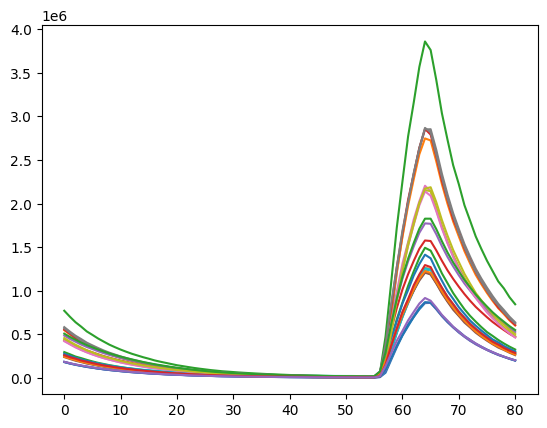

In [14]:
hists_realigned = np.sum(image_4D, axis = (0,1))
plt.figure()
for i in range(nch):
    plt.plot(hists_realigned[:,i])

### APR reconstruction for spatial dimensions

(1250, 1250, 81, 25)
(1250, 1250, 25)


C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:548: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(shift[:, 0], shift[:, 1], s=80, c=color, edgecolors='black', cmap=cmap)


[[-2.75 -0.44]
 [-3.61  0.05]
 [-3.22  1.57]
 [-2.37  3.12]
 [-1.67  6.3 ]
 [-2.63 -1.7 ]
 [-2.62 -0.75]
 [-1.95  0.82]
 [-1.01  2.52]
 [-0.01  4.76]
 [-1.21 -2.54]
 [-0.77 -1.62]
 [ 0.    0.  ]
 [ 0.75  1.62]
 [ 1.72  3.66]
 [ 0.52 -2.73]
 [ 1.25 -2.38]
 [ 2.   -0.74]
 [ 2.69  0.77]
 [ 3.72  2.61]
 [ 2.1  -2.25]
 [ 3.04 -2.71]
 [ 3.97 -1.51]
 [ 4.89  0.03]
 [ 6.77  2.34]]


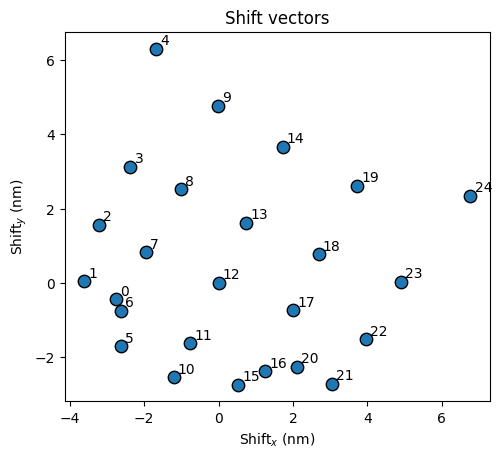

In [13]:
import brighteyes_ism.analysis.APR_lib as apr

print(image_4D.shape)
image_3d = np.sum(image_4D, axis = -2)
print(image_3d.shape)
shift_vectors, err = apr.ShiftVectors(image_3d, usf = 100, ref = 12)
gr.PlotShiftVectors(shift_vectors)
print (shift_vectors)     

In [18]:
from tqdm import tqdm
with h5py.File(r"C:\Users\fdelbufalo\Desktop\images\Lamina_Tubulin\APR_1_Lamina_and_Tubulin", 'w') as f:     
     x_size, y_size, bin_size, channel_size = image_4D.shape[0], image_4D.shape[1], image_4D.shape[2], image_4D.shape[3]
# Create an empty dataset with dimensions (x,y,t, ch)
     dataset_shape = (x_size, y_size, bin_size, channel_size)
     h5_dataset = f.create_dataset('data', shape=dataset_shape, dtype=np.uint16)
    

     

     for bin in tqdm(range(image_4D.shape[-2])):
         h5_dataset[:, :, bin, :] = apr.Reassignment(shift_vectors, image_4D[:, :, bin, :], mode = 'interp')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [25:34<00:00, 18.95s/it]


In [19]:
f = h5py.File(r"C:\Users\fdelbufalo\Desktop\images\Lamina_Tubulin\APR_1_Lamina_and_Tubulin", 'r') 
h5_dataset = f["data"]
print(h5_dataset.shape)
h5_dataset_sum = np.sum(h5_dataset, axis=-1)

(1250, 1250, 81, 25)


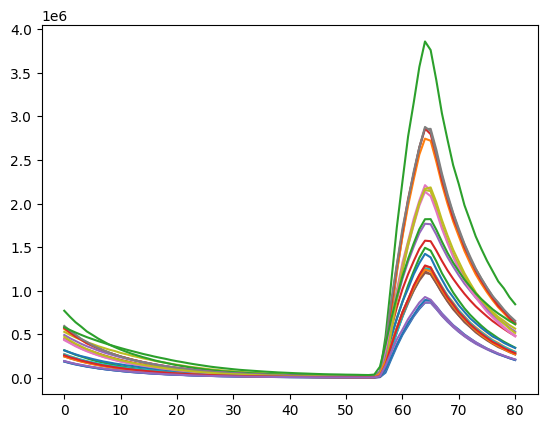

In [20]:
hists_realigned_apr = np.sum(h5_dataset, axis = (0,1))
plt.figure()
for i in range(nch):
    plt.plot(hists_realigned_apr[:,i])

### Plot intensity image (x,y) after performing APR and sum on the temporal bins

(1250, 1250)


(array([9.0500e+02, 4.4460e+03, 5.1730e+03, 5.3270e+03, 6.5290e+03,
        8.3020e+03, 1.1693e+04, 1.5820e+04, 2.0265e+04, 2.5542e+04,
        3.1756e+04, 3.7870e+04, 4.4498e+04, 5.0243e+04, 5.6311e+04,
        6.1883e+04, 6.6157e+04, 7.0110e+04, 7.2476e+04, 7.3290e+04,
        7.3536e+04, 7.2234e+04, 6.8905e+04, 6.4497e+04, 5.9457e+04,
        5.4698e+04, 4.9322e+04, 4.4263e+04, 4.0089e+04, 3.6659e+04,
        3.3948e+04, 3.1213e+04, 2.8373e+04, 2.5200e+04, 2.2603e+04,
        1.9911e+04, 1.8132e+04, 1.6012e+04, 1.4130e+04, 1.2499e+04,
        1.1020e+04, 1.0234e+04, 9.2310e+03, 8.4430e+03, 7.7620e+03,
        7.1110e+03, 6.4390e+03, 5.7490e+03, 5.3580e+03, 4.9240e+03,
        4.2990e+03, 3.8820e+03, 3.2690e+03, 2.9540e+03, 2.4370e+03,
        2.2080e+03, 1.9230e+03, 1.6170e+03, 1.3890e+03, 1.3010e+03,
        1.1200e+03, 9.7300e+02, 7.3300e+02, 6.5100e+02, 5.4600e+02,
        4.5400e+02, 3.7800e+02, 3.2400e+02, 2.2200e+02, 2.1800e+02,
        1.7000e+02, 1.4400e+02, 1.1700e+02, 1.08

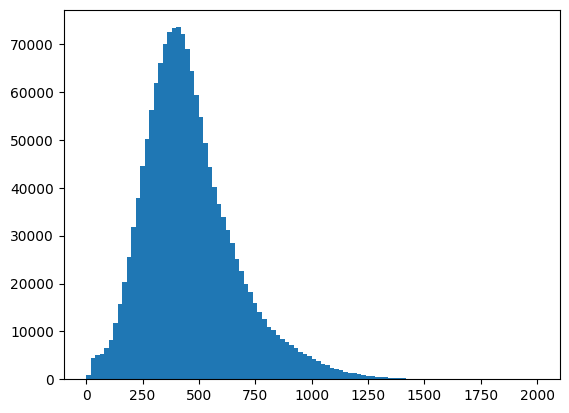

In [22]:
data_histograms = np.sum(h5_dataset_sum, axis = -1)
print(data_histograms.shape)
    
# Plot the histogram of the photon counts in each pixel to see the distribution (e.g. check the level of noise) 
plt.figure()
plt.hist(data_histograms.flatten(), bins = 100, range = (0, 2000))

### Calculate and show the phasor plot of the 3D image without corrections

(1250, 1250)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

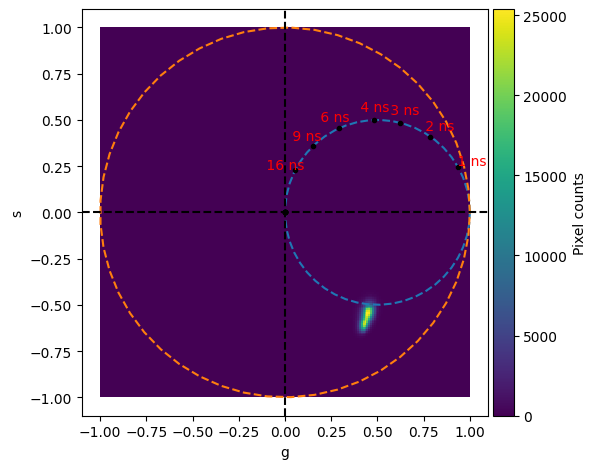

In [23]:
phasor_matrix_1= brighteyes_flim.phasor(h5_dataset_sum)
print(phasor_matrix_1.shape)
brighteyes_flim.plot_phasor(phasor_matrix_1[:], bins_2dplot=200, log_scale=False, quadrant='all', dfd_freq = 41.48e6)

### Extract phasor of the IRF for correcting the measured phasors

(81,)
(-0.23082398665941456-0.9316471611612672j)


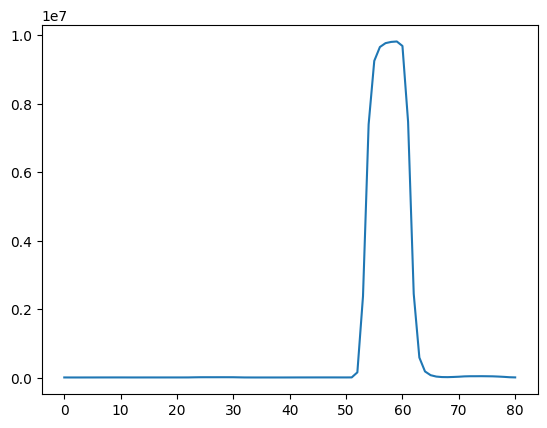

In [25]:
irf_summed = np.sum(irf_shifted, axis = -1)
plt.figure()
plt.plot(irf_summed)
print(irf_summed.shape)
phasor_ir = brighteyes_flim.phasor(irf_summed)
print(phasor_ir)

### Calculate the correction factor from the laser's (26th channel's) phasor to realign the phasors of the data in the phasor plot

In [27]:
data_path = r"C:\Users\fdelbufalo\Desktop\images\Lamina_Tubulin\Lamina.h5"   #change path
data_extra, _ = mcs.load(data_path, key="data_channels_extra")
data_laser = data_extra[:, :, :, :, :, 1]
print(data_laser.shape)
data_laser_hist = np.sum(data_laser, axis = (0,1,2,3))
phasor_laser = brighteyes_flim.calculate_phasor(data_laser_hist)
print(phasor_laser)

(1, 1, 1250, 1250, 81)
(-0.9724567964359583-0.1520894676424419j)


In [28]:
data_extra_irf, _ = mcs.load(data_path_irf, key="data_channels_extra")
data_laser_irf = data_extra_irf[:, :, :, :, :, 1]
print(data_laser_irf.shape)
data_laser_hist_irf = np.sum(data_laser_irf, axis = (0,1,2,3))
phasor_laser_irf = brighteyes_flim.calculate_phasor(data_laser_hist_irf)
print(phasor_laser_irf)

(1, 1, 500, 500, 81)
(-0.981318342643613+0.07627409451078822j)


In [30]:
corr = brighteyes_flim.correction_phasor(data_laser_hist, data_laser_hist_irf)
print(corr)

(0.9730448705798238-0.23061587074244044j)


### Show the phasor plot with the phasors corrected for the IRF and the laser phasor

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

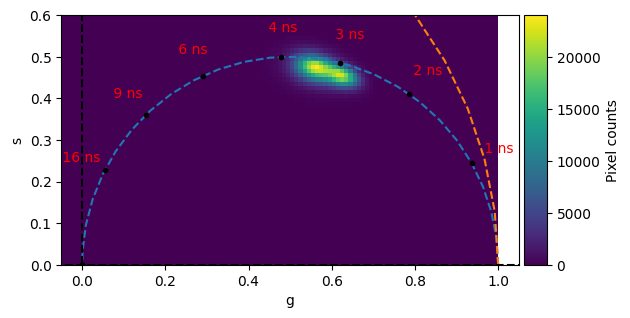

In [33]:
phasor_corrected = phasor_matrix_1 * corr / phasor_ir
brighteyes_flim.plot_phasor(phasor_corrected, bins_2dplot=200, log_scale=False, quadrant='first')

### Lifetime analysis with phasors 

In [35]:
tau_phi = brighteyes_flim.calculate_tau_phi(np.real(phasor_corrected), np.imag(phasor_corrected))
print(tau_phi.shape)

(1250, 1250)


In [36]:
tau_m = brighteyes_flim.calculate_tau_m(np.real(phasor_corrected), np.imag(phasor_corrected))
print(tau_m.shape)

(1250, 1250)


C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\src\brighteyes_flim\flism.py:411: RuntimeWarning: invalid value encountered in sqrt
  tau_m = np.sqrt((1. / (m ** 2)) - 1) / (2 * np.pi * dfd_freq)


(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00, 5.00000e+00,
        3.00000e+00, 6.00000e+00, 1.50000e+01, 2.40000e+01, 4.60000e+01,
        9.20000e+01, 1.74000e+02, 3.53000e+02, 1.02200e+03, 9.54500e+03,
        1.15531e+05, 3.35349e+05, 3.71078e+05, 3.68541e+05, 2.34029e+05,
        8.82210e+04, 2.58890e+04, 7.37500e+03, 2.43800e+03, 1.02100e+03,
        5.82000e+02, 2.95000e+02, 1.88000e+02, 1.29000e+02, 1.02000e+02]),
 array([-6.  , -5.76, -5.52, -5.28, -5.04, -4.8 , -4.56, -4.32, -4.08,
        -3.84, -3.6 , -3.36, -3.12, -2.88, -2.64, -2.4 , -2.16, -1.92,
        -1.68, -1.44, -1.2 , -0.96, -0.72, -0.48, -0.24,  0.  ,  0.24,
         0.48,  0.72,  0.96,  1.2 ,  1.44,  1.68,  1.92

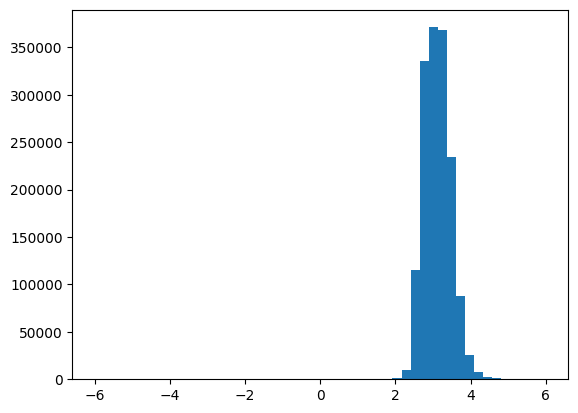

In [37]:
tau_data = 1e9*tau_phi.flatten()

plt.figure()
plt.hist(tau_data, range = (-6, 6), bins = 50)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 4.00000e+00, 3.00000e+00, 1.00000e+01,
        1.30000e+01, 3.60000e+01, 7.00000e+01, 1.72000e+02, 5.27000e+02,
        4.23900e+03, 4.88030e+04, 2.27779e+05, 3.91489e+05, 4.13315e+05,
        2.94017e+05, 1.25625e+05, 3.84590e+04, 1.06440e+04, 3.40800e+03,
        1.38800e+03, 7.24000e+02, 4.40000e+02, 3.22000e+02, 2.38000e+02]),
 array([-6.  , -5.76, -5.52, -5.28, -5.04, -4.8 , -4.56, -4.32, -4.08,
        -3.84, -3.6 , -3.36, -3.12, -2.88, -2.64, -2.4 , -2.16, -1.92,
        -1.68, -1.44, -1.2 , -0.96, -0.72, -0.48, -0.24,  0.  ,  0.24,
         0.48,  0.72,  0.96,  1.2 ,  1.44,  1.68,  1.92

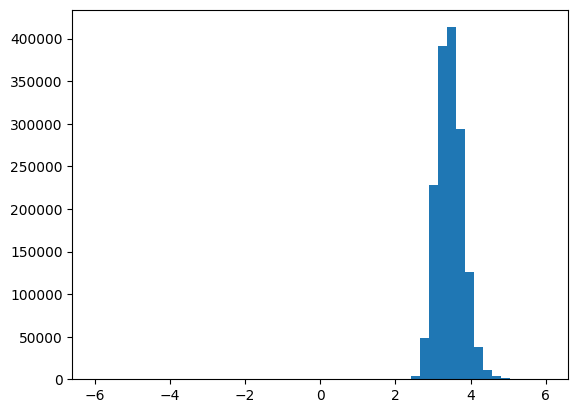

In [38]:
tau_m_data = 1e9*tau_m.flatten()

plt.figure()
plt.hist(tau_m_data, range = (-6, 6), bins = 50)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


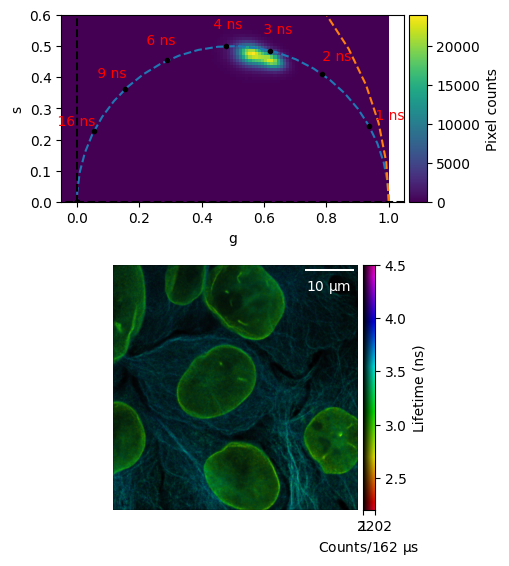

In [90]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
brighteyes_flim.plot_phasor(phasor_corrected, bins_2dplot=200, log_scale=False, quadrant='first', fig = fig, ax = ax1)
gr.show_flim(data_histograms, tau_m*1e9, pxsize = 0.04, pxdwelltime = 162, lifetime_bounds = (2.2, 4.5), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Lamina_Tubulin\APR_tau_M_Lamina_and_Tubulin.pdf", dpi = 900)

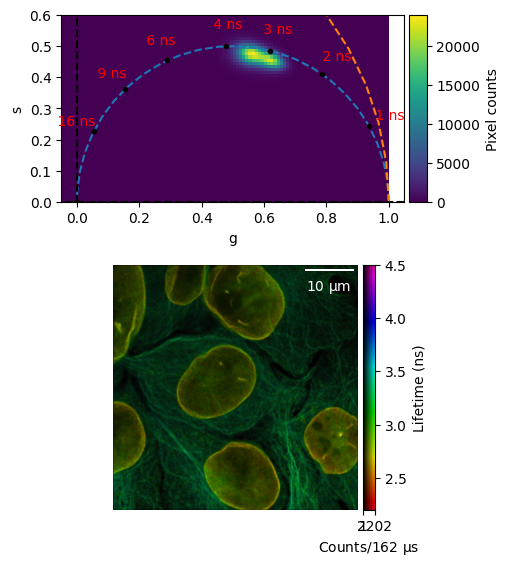

In [89]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
brighteyes_flim.plot_phasor(phasor_corrected, bins_2dplot=200, log_scale=False, quadrant='first', fig = fig, ax = ax1)
gr.show_flim(data_histograms, tau_phi*1e9, pxsize = 0.04, pxdwelltime = 162, lifetime_bounds = (2.2, 4.5), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Lamina_Tubulin\APR_tau_Phi_Lamina_and_Tubulin.pdf", dpi = 900)

### Lifetime analysis with fitting

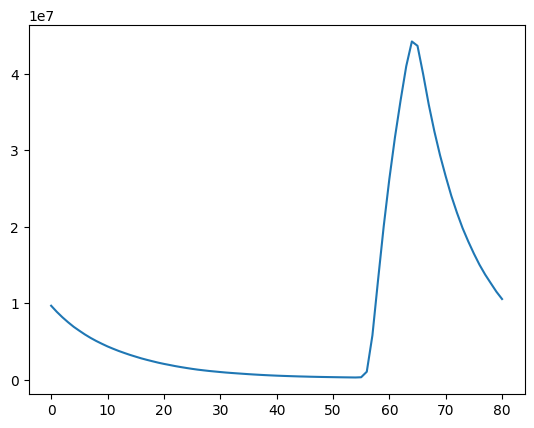

In [42]:
hist_conv = np.sum(h5_dataset_sum, axis = (0,1))  #plot histogram 1D
plt.figure()
plt.plot(hist_conv)

### Test on global fitting

In [46]:
def exp_fun(A, tau, t):
    decay = A * np.exp(-t/tau) 
   # decay[t<0] = 0
    return decay

def model_2(t, A, tau, bkg):
   
    dt = 0.297619 #ns
    nbin = 81
    period = dt * nbin
    
    irf = irf_summed.copy().astype(np.float64)                           ########## change the IRF with the actual IRF for this microscope
    irf/= irf.sum()
    decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
    decay_convolved = scipy.signal.convolve(decay, irf, mode='same')
    decay_convolved =  decay_convolved[nbin//2:-nbin//2]
    return decay_convolved + bkg

def fit_function_2(t, A, tau, bkg):
    return model_2(t, A, tau, bkg)

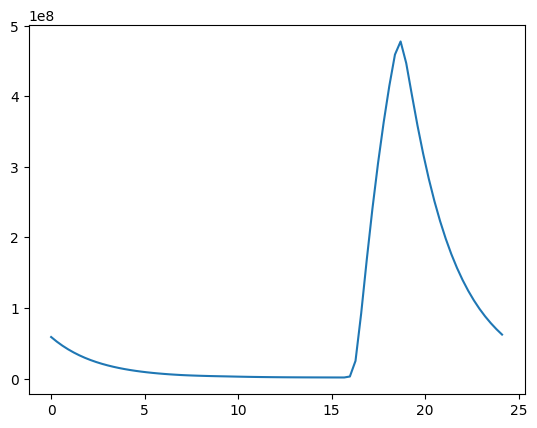

In [47]:
dt = 0.297619 #ns
nbin = 81                                                 #### update the parameters with the one of the DFD
period = dt * nbin
t=np.linspace(-period, period, nbin*2)
t_1 = np.linspace(0, period, nbin) 

decay = (np.heaviside(t, 0) + 1/(np.exp(period/2.5) -1)) * exp_fun(10,2.5,t)
decay_convolved = scipy.signal.convolve(decay, irf_summed, mode='same')
decay_convolved =  decay_convolved[nbin//2:-nbin//2]

plt.figure()
plt.plot(t_1, decay_convolved)

In [49]:
print(np.argmax(decay_convolved))
print(np.argmax(irf_summed))
print(np.argmax(hist_conv))

62
59
64


In [60]:
hist_shifted = shift(hist_conv, -2, order=1, mode='grid-wrap')     ### change the shift value in case
print(np.argmax(hist_shifted))

62


In [61]:
dt = 0.297619 #ns                           ### change the parameters
nbin = 81 
per = dt*nbin
t_axis = np.linspace(-per, per, nbin*2)
initial_guess = [650000, 2.5, 4000]


# Perform the fit
popt, pcov = scipy.optimize.curve_fit(fit_function_2, t_axis, hist_shifted, p0=initial_guess)

# Extract fitted parameters
fitted_A, fitted_tau, fitted_bkg  = popt

In [62]:
print(f"Fitted parameters: A = {fitted_A}, tau = {fitted_tau}, Background noise = {fitted_bkg}")

Fitted parameters: A = 66783270.58418544, tau = 3.2087253623738543, Background noise = 9784.563875744918


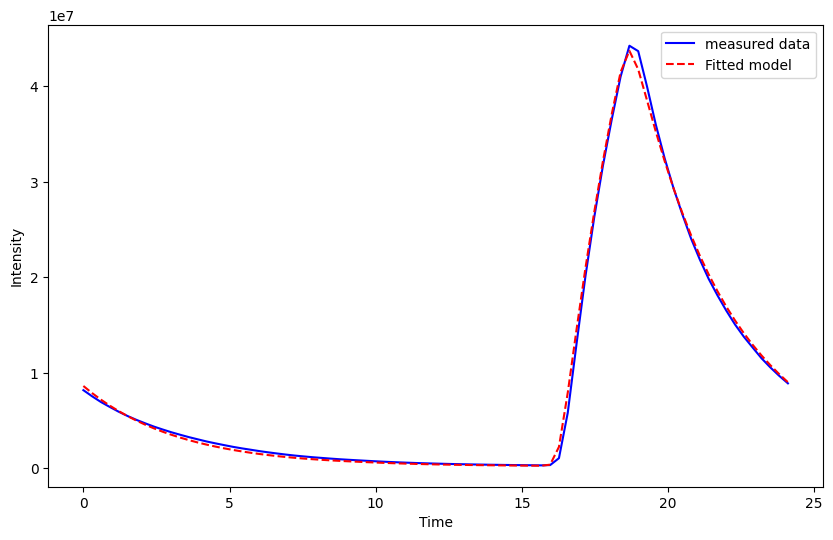

In [63]:
t = np.linspace(0, 24.1, 81)
plt.figure(figsize=(10, 6))
plt.plot(t, hist_shifted, 'b-', label='measured data')
plt.plot(t, fit_function_2(t_axis, *popt), 'r--', label='Fitted model')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

### reconstruct the lifetime in each pixel

In [67]:
lifetime_map = np.zeros((h5_dataset_sum.shape[0], h5_dataset_sum.shape[1]))
background_map = np.zeros((h5_dataset_sum.shape[0], h5_dataset_sum.shape[1]))
initial_guess = [500, 2.5, 50]
dt = 0.297619 #ns
nbin = 81
per = dt*nbin
t_axis = np.linspace(-per, per, nbin*2)

for i in range(h5_dataset_sum.shape[0]):
    for j in range(h5_dataset_sum.shape[1]):
       
        decay_histogram = h5_dataset_sum[i, j, :]
        decay_histogram = shift(decay_histogram, -2, order=1, mode='grid-wrap')       ############### change the shift term
        
        try:
            popt, pcov = scipy.optimize.curve_fit(fit_function_2, t_axis, decay_histogram, p0=initial_guess)
            fitted_tau = popt[1]
            
        
        except RuntimeError:
            fitted_tau = np.nan
        
        
        lifetime_map[i, j] = fitted_tau
       

C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_26268\3056540156.py:2: RuntimeWarning: overflow encountered in exp
  decay = A * np.exp(-t/tau)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_26268\3056540156.py:14: RuntimeWarning: invalid value encountered in multiply
  decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_26268\3056540156.py:14: RuntimeWarning: overflow encountered in exp
  decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_26268\3056540156.py:2: RuntimeWarning: overflow encountered in multiply
  decay = A * np.exp(-t/tau)


(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 6.00000e+00, 2.10000e+01, 2.30000e+01,
        3.60000e+01, 4.10000e+01, 6.20000e+01, 1.13000e+02, 1.52000e+02,
        2.34000e+02, 3.81000e+02, 8.47000e+02, 3.40500e+03, 2.00950e+04,
        9.58070e+04, 2.28129e+05, 2.90647e+05, 2.85389e+05, 2.59136e+05,
        1.87713e+05, 1.04399e+05, 4.81080e+04, 2.03090e+04, 8.51300e+03,
        3.78100e+03, 1.85200e+03, 1.00200e+03, 6.27000e+02, 3.66000e+02,
        2.77000e+02, 1.98000e+02, 1.36000e+02, 1.21000e+02, 6.50000e+01,
        5.80000e+01, 5.20000e+01, 4.00000e+01, 4.00000e+01, 3.00000e+01]),
 array([-3.  , -2.78, -2.56, -2.34, -2.12, -1.9 , -1.68, -1.46, -1.24,
        -1.02, -0.8 , -0.58, -0.36, -0.14,  0.08,  0.3 ,  0.52,  0.74,
         0.96,  1.18,  1.4 ,  1.62,  1.84,  2.06,  2.28,  2.5 ,  2.72,
         2.94,  3.16,  3.38,  3.6 ,  3.82,  4.04,  4.26

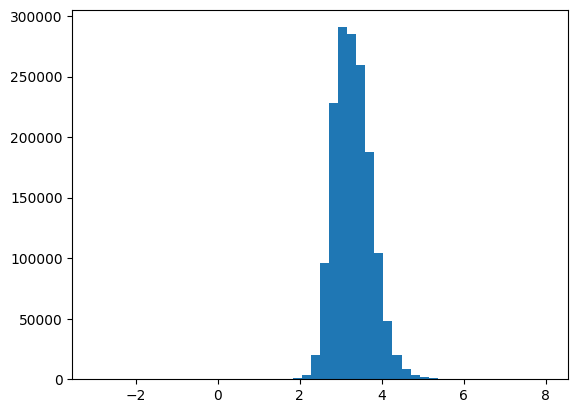

In [68]:
plt.figure()
lifetime_flattened = lifetime_map.flatten()
plt.hist(lifetime_flattened, range = (-3, 8), bins = 50)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


<Figure size 900x600 with 0 Axes>

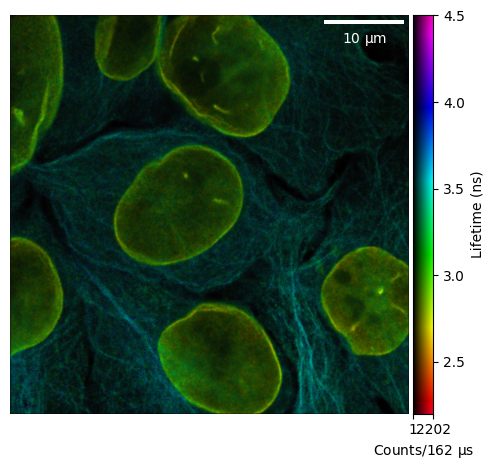

In [88]:
fig = plt.figure(figsize = (9, 6))
gr.show_flim(data_histograms, lifetime_map, pxsize = 0.04, pxdwelltime = 162, lifetime_bounds = (2.2, 4.5), fig = fig)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Lamina_Tubulin\Fitting_APR_Lamina_Tubulin.pdf", dpi = 900)

## Confocal analysis

### Phasor analysis on confocal-like image

In [ ]:
data_3D = image_4D.sum(-1)

(1250, 1250)


(array([8.1900e+02, 4.6390e+03, 5.3790e+03, 5.6310e+03, 6.6350e+03,
        8.7710e+03, 1.2689e+04, 1.6524e+04, 2.1368e+04, 2.7206e+04,
        3.3477e+04, 4.0582e+04, 4.7430e+04, 5.3141e+04, 5.9498e+04,
        6.5315e+04, 6.9783e+04, 7.3014e+04, 7.4822e+04, 7.6290e+04,
        7.5445e+04, 7.2194e+04, 6.8050e+04, 6.2641e+04, 5.7406e+04,
        5.1775e+04, 4.6958e+04, 4.2259e+04, 3.8189e+04, 3.5301e+04,
        3.2131e+04, 2.9397e+04, 2.6474e+04, 2.3688e+04, 2.1108e+04,
        1.9135e+04, 1.7027e+04, 1.5244e+04, 1.3395e+04, 1.2218e+04,
        1.1050e+04, 9.9870e+03, 9.1250e+03, 8.4880e+03, 7.7860e+03,
        6.9590e+03, 6.1700e+03, 5.7270e+03, 5.1080e+03, 4.4970e+03,
        3.9460e+03, 3.4080e+03, 2.8710e+03, 2.4400e+03, 1.9770e+03,
        1.7010e+03, 1.4380e+03, 1.2370e+03, 1.0140e+03, 9.0400e+02,
        7.2400e+02, 6.0400e+02, 4.3900e+02, 3.8100e+02, 2.8100e+02,
        2.3400e+02, 1.8400e+02, 1.5800e+02, 1.4000e+02, 1.0600e+02,
        7.6000e+01, 6.1000e+01, 4.4000e+01, 3.50

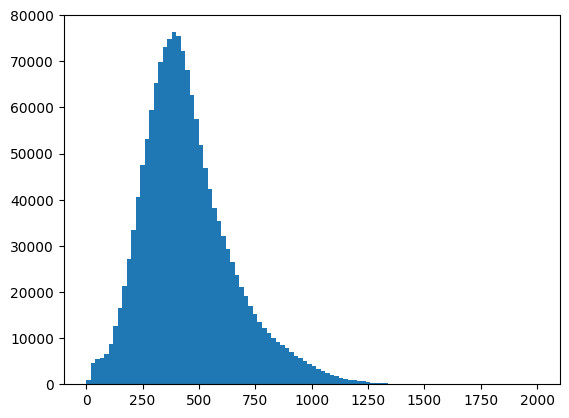

In [73]:
data_histograms_confocal = np.sum(data_3D, axis = -1)
print(data_histograms_confocal.shape)
    
# Plot the histogram of the photon counts in each pixel to see the distribution (e.g. check the level of noise) 
plt.figure()
plt.hist(data_histograms_confocal.flatten(), bins = 100, range = (0, 2000))

(1250, 1250)


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

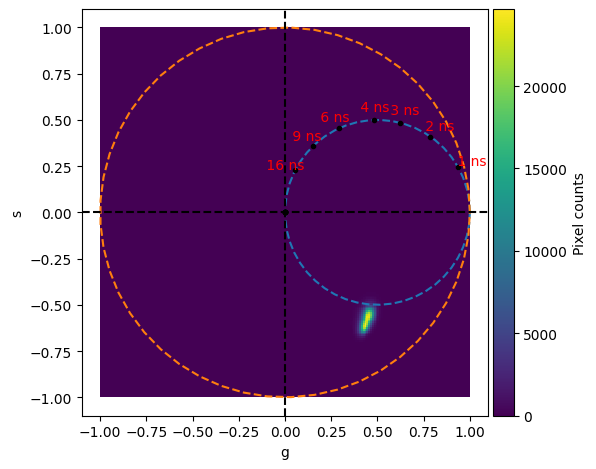

In [74]:
phasor_matrix_confocal= brighteyes_flim.phasor(data_3D)
print(phasor_matrix_confocal.shape)
brighteyes_flim.plot_phasor(phasor_matrix_confocal[:], bins_2dplot=200, log_scale=False, quadrant='all', dfd_freq = 41.48e6)

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='g', ylabel='s'>)

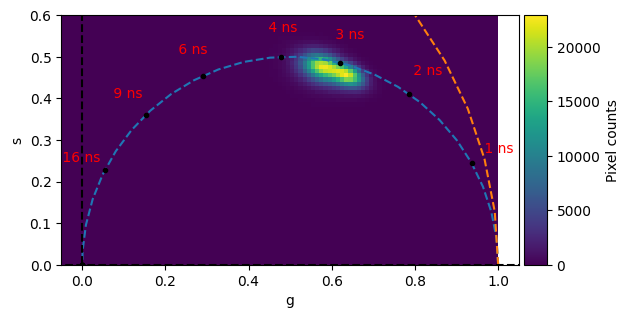

In [75]:
phasor_clean = phasor_matrix_confocal * corr / phasor_ir
brighteyes_flim.plot_phasor(phasor_clean, bins_2dplot=200, log_scale=False, quadrant='first')

In [76]:
tau_phi_confocal = brighteyes_flim.calculate_tau_phi(np.real(phasor_clean), np.imag(phasor_clean))
print(tau_phi_confocal.shape)

(1250, 1250)


In [77]:
tau_m_confocal = brighteyes_flim.calculate_tau_m(np.real(phasor_clean), np.imag(phasor_clean))
print(tau_m_confocal.shape)

(1250, 1250)


C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\src\brighteyes_flim\flism.py:411: RuntimeWarning: invalid value encountered in sqrt
  tau_m = np.sqrt((1. / (m ** 2)) - 1) / (2 * np.pi * dfd_freq)


(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 9.00000e+00, 1.10000e+01, 2.30000e+01, 3.80000e+01,
        1.03000e+02, 1.67000e+02, 4.49000e+02, 1.72400e+03, 2.23750e+04,
        1.77980e+05, 3.80980e+05, 3.92924e+05, 3.34641e+05, 1.72458e+05,
        5.51130e+04, 1.52760e+04, 4.40000e+03, 1.65700e+03, 7.31000e+02,
        4.21000e+02, 2.80000e+02, 1.68000e+02, 1.20000e+02, 8.20000e+01]),
 array([-6.  , -5.76, -5.52, -5.28, -5.04, -4.8 , -4.56, -4.32, -4.08,
        -3.84, -3.6 , -3.36, -3.12, -2.88, -2.64, -2.4 , -2.16, -1.92,
        -1.68, -1.44, -1.2 , -0.96, -0.72, -0.48, -0.24,  0.  ,  0.24,
         0.48,  0.72,  0.96,  1.2 ,  1.44,  1.68,  1.92

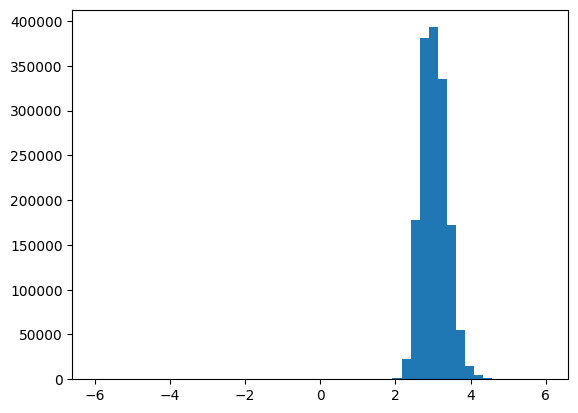

In [78]:
tau_data_confocal = 1e9*tau_phi_confocal.flatten()

plt.figure()
plt.hist(tau_data_confocal, range = (-6, 6), bins = 50)

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 2.00000e+00, 6.00000e+00, 1.30000e+01,
        1.90000e+01, 3.20000e+01, 8.50000e+01, 2.38000e+02, 1.33400e+03,
        1.62340e+04, 1.28027e+05, 3.47201e+05, 4.34340e+05, 3.60155e+05,
        1.84576e+05, 6.24190e+04, 1.73350e+04, 5.26400e+03, 2.04600e+03,
        1.07600e+03, 6.00000e+02, 4.01000e+02, 2.75000e+02, 1.82000e+02]),
 array([-6.  , -5.76, -5.52, -5.28, -5.04, -4.8 , -4.56, -4.32, -4.08,
        -3.84, -3.6 , -3.36, -3.12, -2.88, -2.64, -2.4 , -2.16, -1.92,
        -1.68, -1.44, -1.2 , -0.96, -0.72, -0.48, -0.24,  0.  ,  0.24,
         0.48,  0.72,  0.96,  1.2 ,  1.44,  1.68,  1.92

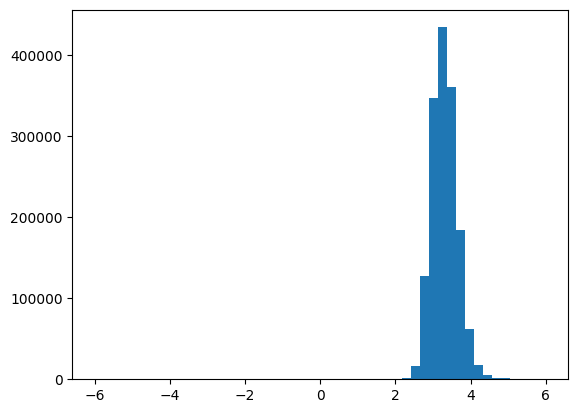

In [79]:
tau_m_data_confocal = 1e9*tau_m_confocal.flatten()

plt.figure()
plt.hist(tau_m_data_confocal, range = (-6, 6), bins = 50)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


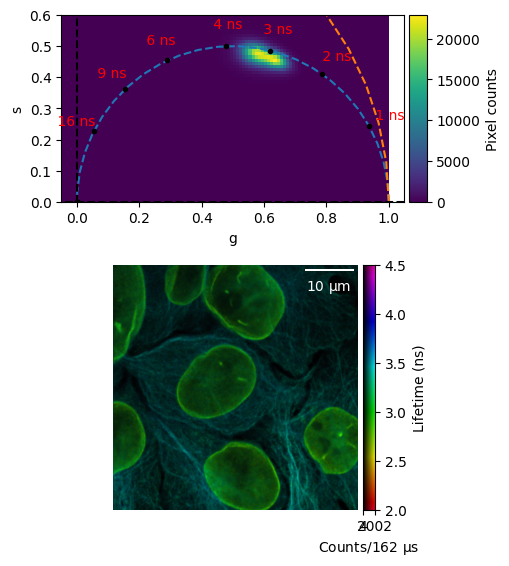

In [91]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
brighteyes_flim.plot_phasor(phasor_clean, bins_2dplot=200, log_scale=False, quadrant='first', fig = fig, ax = ax1)
gr.show_flim(data_histograms_confocal, tau_m_confocal*1e9, pxsize = 0.04, pxdwelltime = 162, lifetime_bounds = (2.0, 4.5), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Lamina_Tubulin\Confocal_tau_M_Lamina_and_Tubulin.pdf", dpi = 900)

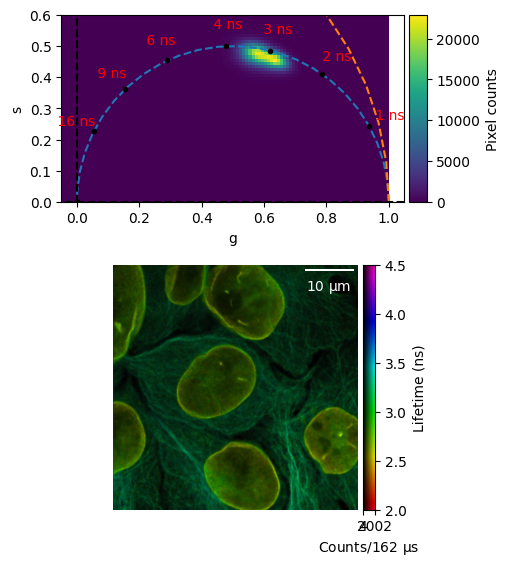

In [92]:
fig = plt.figure(figsize = (9, 6))
gs = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = fig.add_subplot(gs[2:4, 0:2])
brighteyes_flim.plot_phasor(phasor_clean, bins_2dplot=200, log_scale=False, quadrant='first', fig = fig, ax = ax1)
gr.show_flim(data_histograms_confocal, tau_phi_confocal*1e9, pxsize = 0.04, pxdwelltime = 162, lifetime_bounds = (2.0, 4.5), fig = fig, ax = ax2)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Lamina_Tubulin\Confocal_tau_Phi_Lamina_and_Tubulin.pdf", dpi = 900)

### Lifetime analysis on Confocal-like image

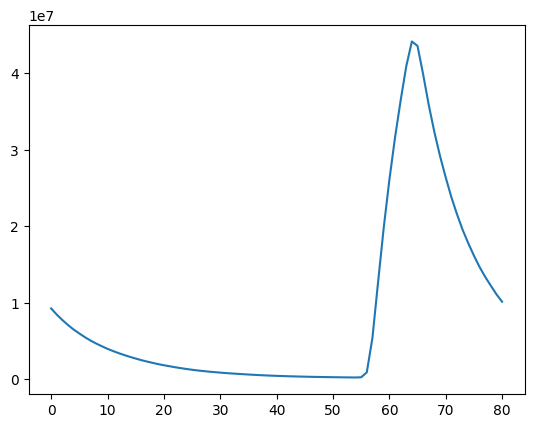

In [93]:
hist_conv_conf = np.sum(data_3D, axis = (0,1))  #plot histogram 1D
plt.figure()
plt.plot(hist_conv_conf)

In [94]:
print(np.argmax(decay_convolved))
print(np.argmax(irf_summed))
print(np.argmax(hist_conv_conf))

62
59
64


In [95]:
hist_shifted_conf = shift(hist_conv_conf, -2, order=1, mode='grid-wrap')     ### change the shift value in case
print(np.argmax(hist_shifted_conf))

62


In [98]:
dt = 0.297619 #ns                           ### change the parameters
nbin = 81 
per = dt*nbin
t_axis = np.linspace(-per, per, nbin*2)
initial_guess_c = [65000, 2.5, 4000]


# Perform the fit
popt_conf, pcov_conf = scipy.optimize.curve_fit(fit_function_2, t_axis, hist_shifted_conf, p0=initial_guess_c)

# Extract fitted parameters
fitted_A_conf, fitted_tau_conf, fitted_bkg_conf  = popt_conf

In [99]:
print(f"Fitted parameters: A = {fitted_A_conf}, tau = {fitted_tau_conf}, Background noise = {fitted_bkg_conf}")

Fitted parameters: A = 67105921.12290305, tau = 3.161238359413207, Background noise = -98013.84364004768


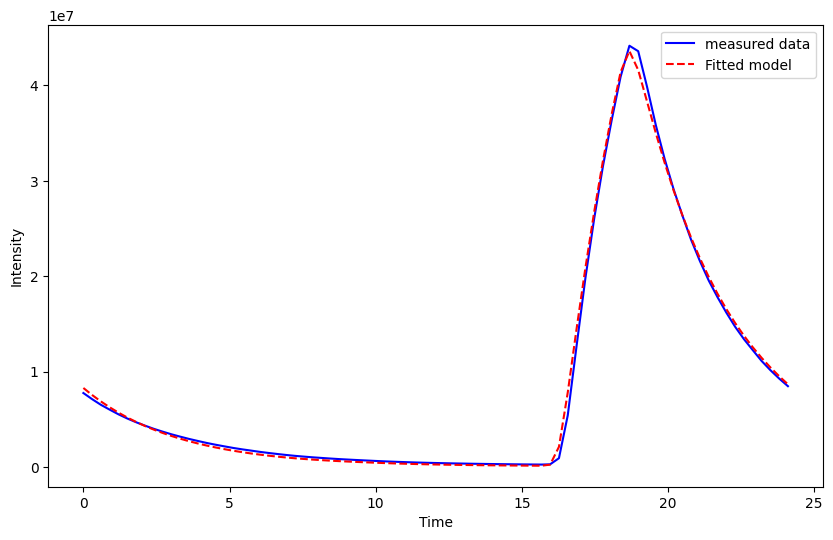

In [102]:
t = np.linspace(0, 24.1, 81)
plt.figure(figsize=(10, 6))
plt.plot(t, hist_shifted_conf, 'b-', label='measured data')
plt.plot(t, fit_function_2(t_axis, *popt_conf), 'r--', label='Fitted model')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

In [105]:
lifetime_map_conf = np.zeros((data_3D.shape[0], data_3D.shape[1]))
background_map_conf = np.zeros((data_3D.shape[0], data_3D.shape[1]))
initial_guess_c = [500, 2.5, 50]
dt = 0.297619 #ns
nbin = 81
per = dt*nbin
t_axis = np.linspace(-per, per, nbin*2)

for i in range(data_3D.shape[0]):
    for j in range(data_3D.shape[1]):
       
        decay_histogram_c = data_3D[i, j, :]
        decay_histogram_c = shift(decay_histogram_c, -2, order=1, mode='grid-wrap')       ############### change the shift term
        
        try:
            popt_c, pcov_c = scipy.optimize.curve_fit(fit_function_2, t_axis, decay_histogram_c, p0=initial_guess_c)
            fitted_tau_c = popt_c[1]
            
        
        except RuntimeError:
            fitted_tau_c = np.nan
        
        
        lifetime_map_conf[i, j] = fitted_tau_c

C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_26268\3056540156.py:14: RuntimeWarning: overflow encountered in exp
  decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_26268\3056540156.py:2: RuntimeWarning: overflow encountered in exp
  decay = A * np.exp(-t/tau)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_26268\3056540156.py:14: RuntimeWarning: invalid value encountered in multiply
  decay = (np.heaviside(t, 0) + 1/(np.exp(period/tau) -1)) * exp_fun(A,tau,t)
C:\Users\fdelbufalo\AppData\Local\Temp\ipykernel_26268\3056540156.py:2: RuntimeWarning: overflow encountered in multiply
  decay = A * np.exp(-t/tau)


(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 3.00000e+00, 2.20000e+01, 1.10000e+01,
        3.30000e+01, 4.30000e+01, 7.10000e+01, 1.12000e+02, 1.60000e+02,
        2.65000e+02, 5.43000e+02, 1.41700e+03, 6.24800e+03, 3.32070e+04,
        1.23058e+05, 2.52210e+05, 3.02837e+05, 2.85709e+05, 2.40670e+05,
        1.62567e+05, 8.54390e+04, 3.83700e+04, 1.57740e+04, 6.55700e+03,
        2.96500e+03, 1.47500e+03, 8.17000e+02, 4.75000e+02, 3.26000e+02,
        2.23000e+02, 1.71000e+02, 1.06000e+02, 9.40000e+01, 8.90000e+01,
        4.90000e+01, 5.30000e+01, 3.50000e+01, 2.30000e+01, 2.40000e+01]),
 array([-3.  , -2.78, -2.56, -2.34, -2.12, -1.9 , -1.68, -1.46, -1.24,
        -1.02, -0.8 , -0.58, -0.36, -0.14,  0.08,  0.3 ,  0.52,  0.74,
         0.96,  1.18,  1.4 ,  1.62,  1.84,  2.06,  2.28,  2.5 ,  2.72,
         2.94,  3.16,  3.38,  3.6 ,  3.82,  4.04,  4.26

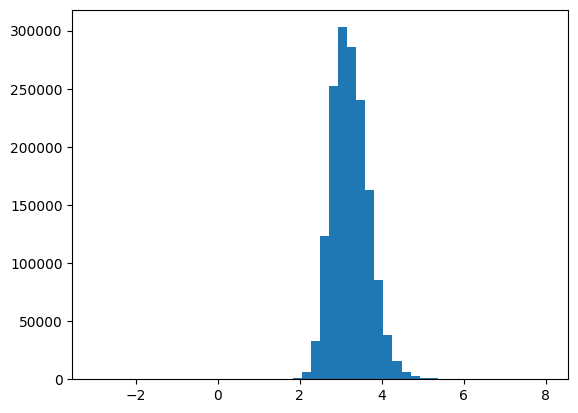

In [106]:
plt.figure()
lifetime_flattened_c = lifetime_map_conf.flatten()
plt.hist(lifetime_flattened_c, range = (-3, 8), bins = 50)

C:\Users\fdelbufalo\PycharmProjects\BrightEyes-Flim\venv\Lib\site-packages\brighteyes_ism\analysis\Graph_lib.py:660: RuntimeWarning: invalid value encountered in cast
  idx = (np.floor((variable - self.var_bounds[0]) / (self.var_bounds[1] - self.var_bounds[0]) * N)).astype(int)


<Figure size 900x600 with 0 Axes>

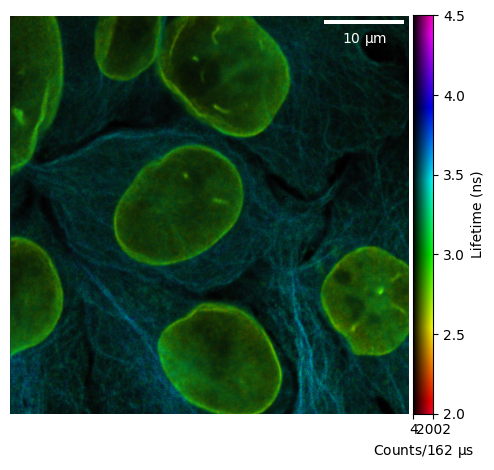

In [107]:
fig = plt.figure(figsize = (9, 6))
gr.show_flim(data_histograms_confocal, lifetime_map_conf, pxsize = 0.04, pxdwelltime = 162, lifetime_bounds = (2.0, 4.5), fig = fig)  
fig.tight_layout()
plt.savefig(r"C:\Users\fdelbufalo\Desktop\PDF_processed_images\Lamina_Tubulin\Fitting_Confocal_Lamina_Tubulin.pdf", dpi = 900)